<a href="https://colab.research.google.com/github/Mengzhe/FreddieMacMortgageProject/blob/main/step3_model_training_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, LSTM
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib

# import shap
import warnings
import time
warnings.filterwarnings("ignore")

import json
from collections import defaultdict

from datetime import datetime
import pytz
from datetime import date


# from bayes_opt import BayesianOptimization

# trained_model_folder_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/"

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

In [3]:
def extract_windows(array, clearing_time_index, max_time, sub_window_size):
    examples = []
    # start = clearing_time_index + 1 - sub_window_size + 1
    start = clearing_time_index - sub_window_size + 1

    for i in range(max_time+1):
        if start+sub_window_size+i<sub_window_size:
            example = np.zeros((sub_window_size, array.shape[1])) ## zero padding
            example[-(start+sub_window_size+i):] = array[:start+sub_window_size+i]
        else:
            example = array[start+i:start+sub_window_size+i]

        examples.append(np.expand_dims(example, 0))
    
    return np.vstack(examples)

def my_roc_auc_score(y_true, y_score):
    ## no positive labels
    if len(np.unique(y_true))==1: 
        return np.nan

    return sklearn.metrics.roc_auc_score(y_true, y_score)

## Load preprocessed data

#### Load train and test dataset

In [4]:
!ls '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/train_test_data'


test_loan_id_arr.npy  test_target_arr.npy    train_orig_arr.npy
test_monthly_arr.npy  train_loan_id_arr.npy  train_target_arr.npy
test_orig_arr.npy     train_monthly_arr.npy


In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/train_test_data'


In [6]:
train_monthly_data = np.load(os.path.join(data_dir, 'train_monthly_arr.npy'))
train_orig_data = np.load(os.path.join(data_dir, 'train_orig_arr.npy'))
train_target_data = np.load(os.path.join(data_dir, 'train_target_arr.npy'))
train_loan_id_data = np.load(os.path.join(data_dir, 'train_loan_id_arr.npy'))

test_monthly_data = np.load(os.path.join(data_dir, 'test_monthly_arr.npy'))
test_orig_data = np.load(os.path.join(data_dir, 'test_orig_arr.npy'))
test_target_data = np.load(os.path.join(data_dir, 'test_target_arr.npy'))
test_loan_id_data = np.load(os.path.join(data_dir, 'test_loan_id_arr.npy'))

print('train_monthly_data.shape', train_monthly_data.shape)
print('train_orig_data.shape', train_orig_data.shape)
print('train_target_data.shape', train_target_data.shape)
print('train_loan_id_data.shape', train_loan_id_data.shape)
print()
print('test_monthly_data.shape', test_monthly_data.shape)
print('test_orig_data.shape', test_orig_data.shape)
print('test_target_data.shape', test_target_data.shape)
print('test_loan_id_data.shape', test_loan_id_data.shape)

train_monthly_data.shape (324443, 24, 13)
train_orig_data.shape (324443, 86)
train_target_data.shape (324443,)
train_loan_id_data.shape (324443,)

test_monthly_data.shape (10503, 24, 13)
test_orig_data.shape (10503, 86)
test_target_data.shape (10503,)
test_loan_id_data.shape (10503,)


In [7]:
dim_monthly = train_monthly_data.shape[1:]
dim_orig = train_orig_data.shape[1:]

In [8]:
mapper_loan_id_train_idx = defaultdict(list)
for i in range(len(train_loan_id_data)):
    mapper_loan_id_train_idx[train_loan_id_data[i]].append(i)
train_loan_id = np.array(list(mapper_loan_id_train_idx.keys()))
print("number of loans in train dataset", len(train_loan_id))

number of loans in train dataset 10797


In [9]:
mapper_loan_id_test_idx = defaultdict(list)
for i in range(len(test_loan_id_data)):
    mapper_loan_id_test_idx[test_loan_id_data[i]].append(i)
test_loan_id = np.array(list(mapper_loan_id_test_idx.keys()))
print("number of loans in test dataset", len(test_loan_id))

number of loans in test dataset 526


In [10]:
counts = np.bincount(tf.cast(train_target_data, tf.int32))
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_target_data)
    ))   
total = counts[0]+counts[1]
weight_for_0 = 1.0 / counts[0] * (total / 2.0)
weight_for_1 = 1.0 / counts[1] * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

Number of positive samples in training data: 55891 (17.23% of total)


In [11]:
counts = np.bincount(tf.cast(test_target_data, tf.int32))
print(
    "Number of positive samples in test data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(test_target_data)
    ))   
total = counts[0]+counts[1]
weight_for_0 = 1.0 / counts[0] * (total / 2.0)
weight_for_1 = 1.0 / counts[1] * (total / 2.0)

Number of positive samples in test data: 4443 (42.30% of total)


In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices(({"monthly_input": train_monthly_data, 
                                                    "orig_input": train_orig_data}, 
                                                    train_target_data))

dataset_test = tf.data.Dataset.from_tensor_slices(({"monthly_input": test_monthly_data, 
                                                    "orig_input": test_orig_data}, 
                                                    test_target_data))

dataset_train = dataset_train.shuffle(buffer_size=1000, seed=42).batch(128)
dataset_test = dataset_test.batch(256)

In [13]:
for x, y in dataset_test.shuffle(buffer_size=1000, seed=0).take(1):
    print("x['monthly_input'].shape", x['monthly_input'].shape)
    print("x['orig_input'].shape", x['orig_input'].shape)
    print('y.shape', y.shape)


x['monthly_input'].shape (256, 24, 13)
x['orig_input'].shape (256, 86)
y.shape (256,)


In [14]:
for x, y in dataset_train.shuffle(buffer_size=1000, seed=0).take(1):
    print("x['monthly_input'].shape", x['monthly_input'].shape)
    print("x['orig_input'].shape", x['orig_input'].shape)
    print('y.shape', y.shape)




x['monthly_input'].shape (128, 24, 13)
x['orig_input'].shape (128, 86)
y.shape (128,)


#### Load preprocessed dataframe

In [15]:
dir_data = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/'
dir_data_combined = os.path.join(dir_data, 'df_combined_2011_2019.csv')
print('dir_data_combined', dir_data_combined)

df_combined = pd.read_csv(dir_data_combined, index_col=0)
df_combined['rep_period_plot'] = pd.to_datetime(df_combined['rep_period'].astype(str), format="%Y%m")
## create a target varible
df_combined.loc[df_combined['zero_bal_code']==1.0, 'target'] = 0 ## paid off
df_combined.loc[df_combined['zero_bal_code'].isin([2.0, 3.0, 9.0]), 'target'] = 1 ## charge off
df_combined.drop(columns=['zero_bal_code'], inplace=True)
## reorder columns
col_names = df_combined.columns.to_list()
col_names = col_names[:9] + ['target'] + col_names[9:-1] 
df_combined = df_combined.loc[:, col_names]
df_combined.head()

dir_data_combined /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/df_combined_2011_2019.csv


,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,int_rate,est_ltv,delq_by_disaster,target,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_ind_sup_cfm,o_credit_score,o_dti,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct,o_chan_B,o_chan_C,o_chan_R,o_purp_C,o_purp_N,o_purp_P,o_first_flag_N,o_first_flag_Y,...,o_prop_st_KY,o_prop_st_LA,o_prop_st_MA,o_prop_st_MD,o_prop_st_ME,o_prop_st_MI,o_prop_st_MN,o_prop_st_MO,o_prop_st_MS,o_prop_st_MT,o_prop_st_NC,o_prop_st_ND,o_prop_st_NE,o_prop_st_NH,o_prop_st_NJ,o_prop_st_NM,o_prop_st_NV,o_prop_st_NY,o_prop_st_OH,o_prop_st_OK,o_prop_st_OR,o_prop_st_PA,o_prop_st_RI,o_prop_st_SC,o_prop_st_SD,o_prop_st_TN,o_prop_st_TX,o_prop_st_UT,o_prop_st_VA,o_prop_st_VT,o_prop_st_WA,o_prop_st_WI,o_prop_st_WV,o_prop_st_WY,o_prop_type_CO,o_prop_type_CP,o_prop_type_MH,o_prop_type_PU,o_prop_type_SF,rep_period_plot
0,F11Q10001082,201304,251430.27,0,26,334,4.375,86.700093,0,NaN,201103,261000,25.0,90,4.375,0,767,39,269.34,269.34,8.2,8.2,0.95,9.73,3.40,3.4,3.8,6.2,4.5,4.5,0.963334,0.072222,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013-04-01
1,F11Q10001082,201305,251043.81,0,27,333,4.375,86.566831,0,NaN,201103,261000,25.0,90,4.375,0,767,39,269.34,269.34,8.0,8.2,0.95,9.73,3.81,3.4,3.8,6.2,4.5,4.5,0.961854,0.075000,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013-05-01
2,F11Q10001082,201306,250655.94,0,28,332,4.375,86.433083,0,NaN,201103,261000,25.0,90,4.375,0,767,39,269.34,269.34,7.9,8.2,0.95,9.73,4.46,3.4,3.8,6.2,4.5,4.5,0.960368,0.077778,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013-06-01
420,F11Q10001082,201307,250266.66,0,29,331,4.375,83.882107,0,NaN,201103,261000,25.0,90,4.375,0,767,39,277.10,269.34,7.8,8.2,0.82,9.32,4.31,3.4,3.3,5.7,4.7,4.5,0.958876,0.080556,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013-07-01
421,F11Q10001082,201308,249875.96,0,30,330,4.375,83.751156,0,NaN,201103,261000,25.0,90,4.375,0,767,39,277.10,269.34,7.7,8.2,0.82,9.32,4.51,3.4,3.3,5.7,4.7,4.5,0.957379,0.083333,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013-08-01


In [16]:
col_names = df_combined.columns.to_list()
col_names = col_names[:9] + ['target'] + col_names[9:-1]
len(col_names)

107

#### create dataset: 1) origination data; 2) monthly data at origination; 3) windowed monthly data

In [17]:
train_monthly_init_data = np.zeros((train_monthly_data.shape[0], train_monthly_data.shape[-1]))
for k in range(len(train_loan_id)):
    loan_id = train_loan_id[k]
    init_step_idx = mapper_loan_id_train_idx[loan_id][0]
    for i, sample_idx in enumerate(mapper_loan_id_train_idx[loan_id]):
        train_monthly_init_data[sample_idx] = train_monthly_data[init_step_idx, -1, :]

test_monthly_init_data = np.zeros((test_monthly_data.shape[0], test_monthly_data.shape[-1]))
for k in range(len(test_loan_id)):
    loan_id = test_loan_id[k]
    init_step_idx = mapper_loan_id_test_idx[loan_id][0]
    for i, sample_idx in enumerate(mapper_loan_id_test_idx[loan_id]):
        test_monthly_init_data[sample_idx] = test_monthly_data[init_step_idx, -1, :]


print("train_monthly_init_data.shape", train_monthly_init_data.shape)
print("test_monthly_init_data.shape", test_monthly_init_data.shape)


train_monthly_init_data.shape (324443, 13)
test_monthly_init_data.shape (10503, 13)


## Model

#### Bayesion optimization for hyperparameters with sample weights

In [18]:
## my score = metric at loan age 0 + mean of the metric at other loan ages
def getMyScore(model):
    test_logits = defaultdict(list)
    for k in range(len(test_loan_id)):
        loan_id = test_loan_id[k]
        selected_indexes = mapper_loan_id_test_idx[loan_id]
        # print("loan_id", loan_id, "age", len(selected_indexes))

        selected_monthly_data = test_monthly_data[selected_indexes]
        selected_orig_data = test_orig_data[selected_indexes]
        selected_monthly_at_orig_data = test_monthly_init_data[selected_indexes]
        selected_target_data = test_target_data[selected_indexes]
        logit = model.predict({"monthly_input": selected_monthly_data, 
                                "orig_input": selected_orig_data, 
                                "monthly_input_at_orig": selected_monthly_at_orig_data})
        proba = tf.math.sigmoid(logit).numpy().flatten().tolist()

        for i in range(len(selected_indexes)):
            test_logits[i].append([proba[i], selected_target_data[i]]) ## age (month): [pred_proba, target_class]
    

    loan_ages = []
    roc_scores = []
    # prc_scores = []
    for age in sorted(test_logits):
        logits_target = np.array(test_logits[age])
        y_pred_proba = logits_target[:, 0]
        y_true = logits_target[:, 1]

        loan_ages.append(age)
        roc_scores.append(my_roc_auc_score(y_true, y_pred_proba))
        # prc_scores.append(sklearn.metrics.average_precision_score(y_true, y_pred_proba))

    loan_ages = np.array(loan_ages)
    roc_scores = np.array(roc_scores)
    # prc_scores = np.array(prc_scores)

    ## metric at loan origination + metric at other times
    my_score = 0.5*roc_scores[0] + 0.5*np.nanmean(roc_scores[1:], )
    return my_score



In [19]:
def getModel_bayes(dim_monthly, dim_orig, dim_monthly_at_orig, learning_rate, dropout_rate):
    x_monthly = Input(shape=dim_monthly, name='monthly_input')
    x_orig = Input(shape=dim_orig, name='orig_input')
    x_monthly_at_orig = Input(shape=dim_monthly_at_orig, name='monthly_input_at_orig')

    z_orig = keras.layers.concatenate([x_monthly_at_orig, x_orig])
    z_orig = Dense(256, activation='relu')(z_orig)
    z_orig = Dropout(dropout_rate)(z_orig)
    z_orig = Dense(128, activation='relu')(z_orig)
    z_orig = Dropout(dropout_rate)(z_orig)
    z_orig = Dense(64, activation='relu')(z_orig)
    z_orig = Dropout(dropout_rate)(z_orig)
    z_orig = Dense(64, activation='relu')(z_orig)
    z_orig = Dropout(dropout_rate)(z_orig)
    z_orig = Dense(32, activation='relu')(z_orig)
    z_orig = Dropout(dropout_rate)(z_orig)
    z_orig = Dense(32, activation='relu')(z_orig)

    z_monthly = LSTM(32, activation='tanh', return_sequences=True, dropout=dropout_rate)(x_monthly)
    # z_monthly = LSTM(32, activation='tanh', return_sequences=True, dropout=dropout_rate)(z_monthly)
    # z_monthly = LSTM(16, activation='tanh', return_sequences=True, dropout=dropout_rate)(z_monthly)
    z_monthly = LSTM(16, activation='tanh', return_sequences=True, dropout=dropout_rate)(z_monthly)
    z_monthly = LSTM(8, activation='tanh')(z_monthly)

    z = keras.layers.concatenate([z_monthly, z_orig])
    z = Dense(64, activation='relu')(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(64, activation='relu')(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(32, activation='relu')(z)
    z = Dense(16, activation='relu')(z)
    z = Dense(1, name='output_logit')(z)
    
    model = Model(inputs=[x_monthly, x_orig, x_monthly_at_orig], 
                  outputs=z)

    model.compile(
                optimizer=keras.optimizers.RMSprop(learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics = [
                        #    keras.metrics.AUC(from_logits=True, 
                        #                         name='prc', 
                        #                         curve='PR'), # precision-recall curve
                            keras.metrics.AUC(from_logits=True, 
                                            name='roc',
                                            curve='ROC'), # roc
                            
                            ], 
                )
    return model

In [20]:
dataset = {
    "train_monthly_input": train_monthly_data, 
    "train_orig_input": train_orig_data,
    "train_monthly_input_at_orig": train_monthly_init_data, 
    "train_target": train_target_data, 
    "train_loan_id": train_loan_id, 
    "test_monthly_input": test_monthly_data, 
    "test_orig_input": test_orig_data,
    "test_monthly_input_at_orig": test_monthly_init_data,
    "test_target": test_target_data, 
    "test_loan_id": test_loan_id, 
}

def bayes_parameter_opt(dataset,
                        init_round=15,
                        opt_round=25):
    
    EPOCHS = 20

    train_monthly_data = dataset["train_monthly_input"]
    train_orig_data = dataset["train_orig_input"]
    train_monthly_init_data = dataset["train_monthly_input_at_orig"]
    train_target_data = dataset["train_target"]
    train_loan_id = dataset["train_loan_id"]

    counts = np.bincount(tf.cast(train_target_data, tf.int32))
    # print(
    #     "Number of positive samples in training data: {} ({:.2f}% of total)".format(
    #         counts[1], 100 * float(counts[1]) / len(train_target_data)
    #     ))   
    total = counts[0]+counts[1]
    weight_for_0 = 1.0 / counts[0] * (total / 2.0)
    weight_for_1 = 1.0 / counts[1] * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    test_monthly_data = dataset["test_monthly_input"]
    test_orig_data = dataset["test_orig_input"]
    test_monthly_init_data = dataset["test_monthly_input_at_orig"]
    test_target_data = dataset["test_target"]
    test_loan_id = dataset["test_loan_id"]

    def model_eval(exp_learning_rate, dropout_rate, sample_weight_decay):
        learning_rate = 10 ** exp_learning_rate
        model = getModel_bayes(dim_monthly=train_monthly_data.shape[1:], 
                               dim_orig=train_orig_data.shape[1:], 
                               dim_monthly_at_orig=train_monthly_init_data.shape[1:],
                               learning_rate=learning_rate, 
                               dropout_rate=dropout_rate)
        
        sample_weight = np.ones_like(train_target_data)
        for k in range(len(train_loan_id)):
            loan_id = train_loan_id[k]
            for i, sample_idx in enumerate(mapper_loan_id_train_idx[loan_id]):
                sample_weight[sample_idx] *= sample_weight_decay**i

        ## create tf.dataset objects
        dataset_train = tf.data.Dataset.from_tensor_slices(({"monthly_input": train_monthly_data, 
                                                              "orig_input": train_orig_data, 
                                                              "monthly_input_at_orig": train_monthly_init_data}, 
                                                             train_target_data, 
                                                             sample_weight))

        dataset_test = tf.data.Dataset.from_tensor_slices(({"monthly_input": test_monthly_data, 
                                                            "orig_input": test_orig_data,
                                                            "monthly_input_at_orig": test_monthly_init_data},
                                                            test_target_data))

        dataset_train = dataset_train.shuffle(buffer_size=5000, seed=42).batch(128)
        dataset_test = dataset_test.batch(256)

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_roc', 
                                                          verbose=0,
                                                          patience=5,
                                                          mode='max')
        
        history = model.fit(dataset_train, 
                            validation_data=dataset_test, 
                            epochs=EPOCHS, 
                            callbacks=[early_stopping],
                            class_weight=class_weight, 
                            verbose=0
                            )
        score = getMyScore(model)
        return score

    modelBO = BayesianOptimization(model_eval, {
                                                'exp_learning_rate': (-5, -2), 
                                                'dropout_rate': (0, 0.5), 
                                                'sample_weight_decay': (0, 1), 
                                                }, 
                                   verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
                                #    random_state=0
                                   )
    # try:
    # New optimizer is loaded with previously seen points
    load_logs(modelBO, logs=["/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/logs_20210810_2242.json",
                             "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/logs_20210810_2314.json",
                             "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/logs_20210811_0007.json",
                             "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/logs_20210811_1500.json",
                             ])
    # except:
    #     pass

    now = datetime.now()
    utc = pytz.utc
    utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
    eastern = pytz.timezone('US/Eastern')
    loc_dt = utc_dt.astimezone(eastern)
    fmt = '%Y%m%d_%H%M'
    cur_datetime = loc_dt.strftime(fmt)

    save_path = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/logs_{cur_datetime}.json".format(cur_datetime=cur_datetime)
    logger = JSONLogger(path=save_path)
    modelBO.subscribe(Events.OPTIMIZATION_STEP, logger)

    # optimize
    modelBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return modelBO

In [21]:
# %%time
# # print('target: roc-auc')
# modelBO = bayes_parameter_opt(dataset,
#                               init_round=5,
#                               opt_round=10)

# modelBO_res = pd.DataFrame(modelBO.res)
# now = datetime.now()
# utc = pytz.utc
# utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
# eastern = pytz.timezone('US/Eastern')
# loc_dt = utc_dt.astimezone(eastern)
# fmt = '%Y%m%d_%H%M'
# cur_datetime = loc_dt.strftime(fmt)
# # cur_datetime

# save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results'
# score = max(modelBO_res['target'])
# score = str(round(score, 4))[-4:]
# saved_bay_opt_res_name = "bo_{cur_datetime}_my_score_{score}.csv".format(cur_datetime=cur_datetime, 
#                                                                          score=score)
# modelBO_res.to_csv(os.path.join(save_path, saved_bay_opt_res_name))
# print(os.path.join(save_path, saved_bay_opt_res_name))


In [22]:
# modelBO_res

In [23]:
modelBO_res = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/bo_20210811_1759_my_score_8559.csv") 

# best_params = modelBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
best_params = modelBO_res.sort_values(by='target', ascending=False).reset_index().loc[3, 'params']
best_params = best_params.replace("'", '"')
best_params = json.loads(best_params)
best_params = dict(best_params)

learning_rate = 10 ** best_params['exp_learning_rate']
best_params['learning_rate'] = learning_rate
del best_params['exp_learning_rate']
best_params

{'dropout_rate': 0.04543933665910943,
 'learning_rate': 0.00013561602664502817,
 'sample_weight_decay': 0.8805086255923434}

In [24]:
# EPOCHS = 100
# model = getModel_bayes(dim_monthly=train_monthly_data.shape[1:], 
#                         dim_orig=train_orig_data.shape[1:], 
#                         dim_monthly_at_orig=train_monthly_init_data.shape[1:],
#                         learning_rate=best_params['learning_rate'], 
#                         dropout_rate=best_params['dropout_rate'])

# ## sample_weight
# sample_weight_decay = best_params['sample_weight_decay']
# sample_weight = np.ones_like(train_target_data)
# for k in range(len(train_loan_id)):
#     loan_id = train_loan_id[k]
#     for i, sample_idx in enumerate(mapper_loan_id_train_idx[loan_id]):
#         sample_weight[sample_idx] *= sample_weight_decay**i

# ## create tf.dataset objects
# dataset_train = tf.data.Dataset.from_tensor_slices(({"monthly_input": train_monthly_data, 
#                                                         "orig_input": train_orig_data, 
#                                                         "monthly_input_at_orig": train_monthly_init_data}, 
#                                                         train_target_data, 
#                                                         sample_weight))

# dataset_test = tf.data.Dataset.from_tensor_slices(({"monthly_input": test_monthly_data, 
#                                                     "orig_input": test_orig_data,
#                                                     "monthly_input_at_orig": test_monthly_init_data},
#                                                     test_target_data))

# dataset_train = dataset_train.shuffle(buffer_size=5000, seed=42).batch(128)
# dataset_test = dataset_test.batch(256)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_roc', 
#                                                     verbose=1,
#                                                     restore_best_weights=True,
#                                                     patience=10,
#                                                     mode='max')

# history = model.fit(dataset_train, 
#                     validation_data=dataset_test, 
#                     epochs=EPOCHS, 
#                     callbacks=[early_stopping],
#                     class_weight=class_weight, 
#                     verbose=1
#                     )


In [25]:
# now = datetime.now()
# utc = pytz.utc
# utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
# eastern = pytz.timezone('US/Eastern')
# loc_dt = utc_dt.astimezone(eastern)
# fmt = '%Y%m%d_%H%M'
# cur_datetime = loc_dt.strftime(fmt)
# # cur_datetime

# save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results'
# score = getMyScore(model) 
# score = str(round(score, 4))[-4:]
# model_name = "model_{cur_datetime}_my_score_{score}.h5".format(cur_datetime=cur_datetime, 
#                                                                   score=score)
# saved_model_name = os.path.join(save_path, model_name)
# print(model_name)
# model.save(saved_model_name)

In [26]:
# model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results/model_20210811_1625_my_score_8517.h5")

In [27]:
# keras.utils.plot_model(model, show_shapes=True)

In [28]:
# %%time
# test_logits = defaultdict(list)
# for k in range(len(test_loan_id)):
#     loan_id = test_loan_id[k]
#     selected_indexes = mapper_loan_id_test_idx[loan_id]
#     # print("loan_id", loan_id, "age", len(selected_indexes))

#     selected_monthly_data = test_monthly_data[selected_indexes]
#     selected_orig_data = test_orig_data[selected_indexes]
#     selected_monthly_at_orig_data = test_monthly_init_data[selected_indexes]
#     selected_target_data = test_target_data[selected_indexes]
#     logit = model.predict({"monthly_input": selected_monthly_data, 
#                            "orig_input": selected_orig_data, 
#                            "monthly_input_at_orig": selected_monthly_at_orig_data})
#     proba = tf.math.sigmoid(logit).numpy().flatten().tolist()

#     for i in range(len(selected_indexes)):
#         test_logits[i].append([proba[i], selected_target_data[i]]) ## age (month): [pred_proba, target_class]


In [29]:
# loan_ages = []
# roc_scores = []
# prc_scores = []
# precision_scores = []
# rec_scores = []
# f1_scores = []
# acc_scores = []
# for age in sorted(test_logits):
#     logits_target = np.array(test_logits[age])
#     y_pred_proba = logits_target[:, 0]
#     y_true = logits_target[:, 1]

#     # print("age", age)
#     # print("age", age, 
#     #       "roc", my_roc_auc_score(y_true, y_pred_proba), 
#     #       "prc", sklearn.metrics.average_precision_score(y_true, y_pred_proba))
#     loan_ages.append(age)
#     roc_scores.append(my_roc_auc_score(y_true, y_pred_proba))
#     prc_scores.append(sklearn.metrics.average_precision_score(y_true, y_pred_proba))
#     precision_scores.append(sklearn.metrics.precision_score(y_true, np.round(y_pred_proba)))
#     rec_scores.append(sklearn.metrics.recall_score(y_true, np.round(y_pred_proba)))
#     f1_scores.append(sklearn.metrics.f1_score(y_true, np.round(y_pred_proba)))
#     acc_scores.append(sklearn.metrics.accuracy_score(y_true, np.round(y_pred_proba)))

# loan_ages = np.array(loan_ages)
# roc_scores = np.array(roc_scores)
# prc_scores = np.array(prc_scores)
# precision_scores = np.array(precision_scores)
# rec_scores = np.array(rec_scores)
# f1_scores = np.array(f1_scores)
# acc_scores = np.array(acc_scores)

In [30]:
# ## metrics at different loan ages

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# _ = ax.plot(loan_ages, roc_scores, label="roc")
# _ = ax.plot(loan_ages, prc_scores, label="prc")
# _ = ax.plot(loan_ages, precision_scores, label="precision")
# _ = ax.plot(loan_ages, rec_scores, label="recall")
# _ = ax.plot(loan_ages, f1_scores, label="f1_score")
# _ = ax.plot(loan_ages, acc_scores, label="accuracy")

# ax.legend(fontsize=14)
# ax.set_xlabel("loan age", Fontsize=16)
# ax.set_ylabel("metrics", Fontsize=16)


In [31]:
# roc_scores

In [32]:
# prc_scores

#### Bayesion optimization for hyperparameters without sample weight

In [33]:
dataset = {
    "train_monthly_input": train_monthly_data, 
    "train_orig_input": train_orig_data,
    "train_monthly_input_at_orig": train_monthly_init_data, 
    "train_target": train_target_data, 
    "train_loan_id": train_loan_id, 
    "test_monthly_input": test_monthly_data, 
    "test_orig_input": test_orig_data,
    "test_monthly_input_at_orig": test_monthly_init_data,
    "test_target": test_target_data, 
    "test_loan_id": test_loan_id, 
}

def bayes_parameter_opt(dataset,
                        init_round=15,
                        opt_round=25):
    
    EPOCHS = 20

    train_monthly_data = dataset["train_monthly_input"]
    train_orig_data = dataset["train_orig_input"]
    train_monthly_init_data = dataset["train_monthly_input_at_orig"]
    train_target_data = dataset["train_target"]
    train_loan_id = dataset["train_loan_id"]

    counts = np.bincount(tf.cast(train_target_data, tf.int32))
    # print(
    #     "Number of positive samples in training data: {} ({:.2f}% of total)".format(
    #         counts[1], 100 * float(counts[1]) / len(train_target_data)
    #     ))   
    total = counts[0]+counts[1]
    weight_for_0 = 1.0 / counts[0] * (total / 2.0)
    weight_for_1 = 1.0 / counts[1] * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    test_monthly_data = dataset["test_monthly_input"]
    test_orig_data = dataset["test_orig_input"]
    test_monthly_init_data = dataset["test_monthly_input_at_orig"]
    test_target_data = dataset["test_target"]
    test_loan_id = dataset["test_loan_id"]

    def model_eval(exp_learning_rate, dropout_rate):
        learning_rate = 10 ** exp_learning_rate
        model = getModel_bayes(dim_monthly=train_monthly_data.shape[1:], 
                               dim_orig=train_orig_data.shape[1:], 
                               dim_monthly_at_orig=train_monthly_init_data.shape[1:],
                               learning_rate=learning_rate, 
                               dropout_rate=dropout_rate)
        
        # sample_weight = np.ones_like(train_target_data)
        # for k in range(len(train_loan_id)):
        #     loan_id = train_loan_id[k]
        #     for i, sample_idx in enumerate(mapper_loan_id_train_idx[loan_id]):
        #         sample_weight[sample_idx] *= sample_weight_decay**i

        ## create tf.dataset objects
        dataset_train = tf.data.Dataset.from_tensor_slices(({"monthly_input": train_monthly_data, 
                                                              "orig_input": train_orig_data, 
                                                              "monthly_input_at_orig": train_monthly_init_data}, 
                                                             train_target_data))

        dataset_test = tf.data.Dataset.from_tensor_slices(({"monthly_input": test_monthly_data, 
                                                            "orig_input": test_orig_data,
                                                            "monthly_input_at_orig": test_monthly_init_data},
                                                            test_target_data))

        dataset_train = dataset_train.shuffle(buffer_size=5000, seed=42).batch(128)
        dataset_test = dataset_test.batch(256)

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_roc', 
                                                          verbose=0,
                                                          patience=5,
                                                          mode='max')
        
        history = model.fit(dataset_train, 
                            validation_data=dataset_test, 
                            epochs=EPOCHS, 
                            callbacks=[early_stopping],
                            class_weight=class_weight, 
                            verbose=0
                            )
        score = getMyScore(model)
        return score

    modelBO = BayesianOptimization(model_eval, {
                                                'exp_learning_rate': (-5, -2), 
                                                'dropout_rate': (0, 0.5),  
                                                }, 
                                   verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
                                #    random_state=0
                                   )
    # try:
    # New optimizer is loaded with previously seen points
    load_logs(modelBO, logs=["/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/logs_20210810_1513.json", 
                             "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/logs_20210810_1534.json", 
                             "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/logs_20210810_1629.json",
                             ])
    # except:
    #     pass

    now = datetime.now()
    utc = pytz.utc
    utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
    eastern = pytz.timezone('US/Eastern')
    loc_dt = utc_dt.astimezone(eastern)
    fmt = '%Y%m%d_%H%M'
    cur_datetime = loc_dt.strftime(fmt)

    save_path = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/logs_{cur_datetime}.json".format(cur_datetime=cur_datetime)
    logger = JSONLogger(path=save_path)
    modelBO.subscribe(Events.OPTIMIZATION_STEP, logger)

    # optimize
    modelBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return modelBO

In [34]:
# %%time
# # print('target: roc-auc')
# modelBO = bayes_parameter_opt(dataset,
#                               init_round=5,
#                               opt_round=5)

# modelBO_res = pd.DataFrame(modelBO.res)
# now = datetime.now()
# utc = pytz.utc
# utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
# eastern = pytz.timezone('US/Eastern')
# loc_dt = utc_dt.astimezone(eastern)
# fmt = '%Y%m%d_%H%M'
# cur_datetime = loc_dt.strftime(fmt)
# # cur_datetime

# save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw'
# score = max(modelBO_res['target'])
# score = str(round(score, 4))[-4:]
# saved_bay_opt_res_name = "bo_{cur_datetime}_my_score_{score}.csv".format(cur_datetime=cur_datetime, 
#                                                                          score=score)
# modelBO_res.to_csv(os.path.join(save_path, saved_bay_opt_res_name))
# print(os.path.join(save_path, saved_bay_opt_res_name))


In [35]:
# modelBO_res

In [36]:
modelBO_res = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/bo_20210810_2158_my_score_8545.csv") 

best_params = modelBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
best_params = best_params.replace("'", '"')
best_params = json.loads(best_params)
best_params = dict(best_params)

learning_rate = 10 ** best_params['exp_learning_rate']
best_params['learning_rate'] = learning_rate
del best_params['exp_learning_rate']
best_params

{'dropout_rate': 0.20021569458445726, 'learning_rate': 5.076846348500407e-05}

In [37]:
# EPOCHS = 100
# model = getModel_bayes(dim_monthly=train_monthly_data.shape[1:], 
#                         dim_orig=train_orig_data.shape[1:], 
#                         dim_monthly_at_orig=train_monthly_init_data.shape[1:],
#                         learning_rate=best_params['learning_rate'], 
#                         dropout_rate=best_params['dropout_rate'])

# ## create tf.dataset objects
# dataset_train = tf.data.Dataset.from_tensor_slices(({"monthly_input": train_monthly_data, 
#                                                         "orig_input": train_orig_data, 
#                                                         "monthly_input_at_orig": train_monthly_init_data}, 
#                                                         train_target_data))

# dataset_test = tf.data.Dataset.from_tensor_slices(({"monthly_input": test_monthly_data, 
#                                                     "orig_input": test_orig_data,
#                                                     "monthly_input_at_orig": test_monthly_init_data},
#                                                     test_target_data))

# dataset_train = dataset_train.shuffle(buffer_size=5000, seed=42).batch(128)
# dataset_test = dataset_test.batch(256)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_roc', 
#                                                     verbose=1,
#                                                     restore_best_weights=True,
#                                                     patience=10,
#                                                     mode='max')

# history = model.fit(dataset_train, 
#                     validation_data=dataset_test, 
#                     epochs=EPOCHS, 
#                     callbacks=[early_stopping],
#                     class_weight=class_weight, 
#                     verbose=1
#                     )
# # score = getMyScore(model) 

In [38]:
# now = datetime.now()
# utc = pytz.utc
# utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
# eastern = pytz.timezone('US/Eastern')
# loc_dt = utc_dt.astimezone(eastern)
# fmt = '%Y%m%d_%H%M'
# cur_datetime = loc_dt.strftime(fmt)
# # cur_datetime

# save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw'
# score = getMyScore(model) 
# score = str(round(score, 4))[-4:]
# model_name = "model_{cur_datetime}_my_score_{score}.h5".format(cur_datetime=cur_datetime, 
#                                                                   score=score)
# saved_model_name = os.path.join(save_path, model_name)
# print(model_name)
# model.save(saved_model_name)

In [39]:
# model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/model_20210810_2228_my_score_8577.h5")

In [40]:
# %%time
# test_logits = defaultdict(list)
# for k in range(len(test_loan_id)):
#     loan_id = test_loan_id[k]
#     selected_indexes = mapper_loan_id_test_idx[loan_id]
#     # print("loan_id", loan_id, "age", len(selected_indexes))

#     selected_monthly_data = test_monthly_data[selected_indexes]
#     selected_orig_data = test_orig_data[selected_indexes]
#     selected_monthly_at_orig_data = test_monthly_init_data[selected_indexes]
#     selected_target_data = test_target_data[selected_indexes]
#     logit = model.predict({"monthly_input": selected_monthly_data, 
#                            "orig_input": selected_orig_data, 
#                            "monthly_input_at_orig": selected_monthly_at_orig_data})
#     proba = tf.math.sigmoid(logit).numpy().flatten().tolist()

#     for i in range(len(selected_indexes)):
#         test_logits[i].append([proba[i], selected_target_data[i]]) ## age (month): [pred_proba, target_class]


In [41]:
# loan_ages = []
# roc_scores = []
# prc_scores = []
# precision_scores = []
# rec_scores = []
# f1_scores = []
# acc_scores = []
# for age in sorted(test_logits):
#     logits_target = np.array(test_logits[age])
#     y_pred_proba = logits_target[:, 0]
#     y_true = logits_target[:, 1]

#     # print("age", age)
#     # print("age", age, 
#     #       "roc", my_roc_auc_score(y_true, y_pred_proba), 
#     #       "prc", sklearn.metrics.average_precision_score(y_true, y_pred_proba))
#     loan_ages.append(age)
#     roc_scores.append(my_roc_auc_score(y_true, y_pred_proba))
#     prc_scores.append(sklearn.metrics.average_precision_score(y_true, y_pred_proba))
#     precision_scores.append(sklearn.metrics.precision_score(y_true, np.round(y_pred_proba)))
#     rec_scores.append(sklearn.metrics.recall_score(y_true, np.round(y_pred_proba)))
#     f1_scores.append(sklearn.metrics.f1_score(y_true, np.round(y_pred_proba)))
#     acc_scores.append(sklearn.metrics.accuracy_score(y_true, np.round(y_pred_proba)))

# loan_ages = np.array(loan_ages)
# roc_scores = np.array(roc_scores)
# prc_scores = np.array(prc_scores)
# precision_scores = np.array(precision_scores)
# rec_scores = np.array(rec_scores)
# f1_scores = np.array(f1_scores)
# acc_scores = np.array(acc_scores)

In [42]:
# ## metrics at different loan ages

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# _ = ax.plot(loan_ages, roc_scores, label="roc")
# _ = ax.plot(loan_ages, prc_scores, label="prc")
# # _ = ax.plot(loan_ages, precision_scores, label="precision")
# # _ = ax.plot(loan_ages, rec_scores, label="recall")
# # _ = ax.plot(loan_ages, f1_scores, label="f1_score")
# # _ = ax.plot(loan_ages, acc_scores, label="accuracy")

# ax.legend(fontsize=14)
# ax.set_xlabel("loan age", Fontsize=16)
# ax.set_ylabel("metrics", Fontsize=16)


In [43]:
# roc_scores

In [44]:
# prc_scores

## Model Evaluation

#### Load Model

In [45]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/trained_models/bo_results_wo_sw/model_20210810_2228_my_score_8577.h5")

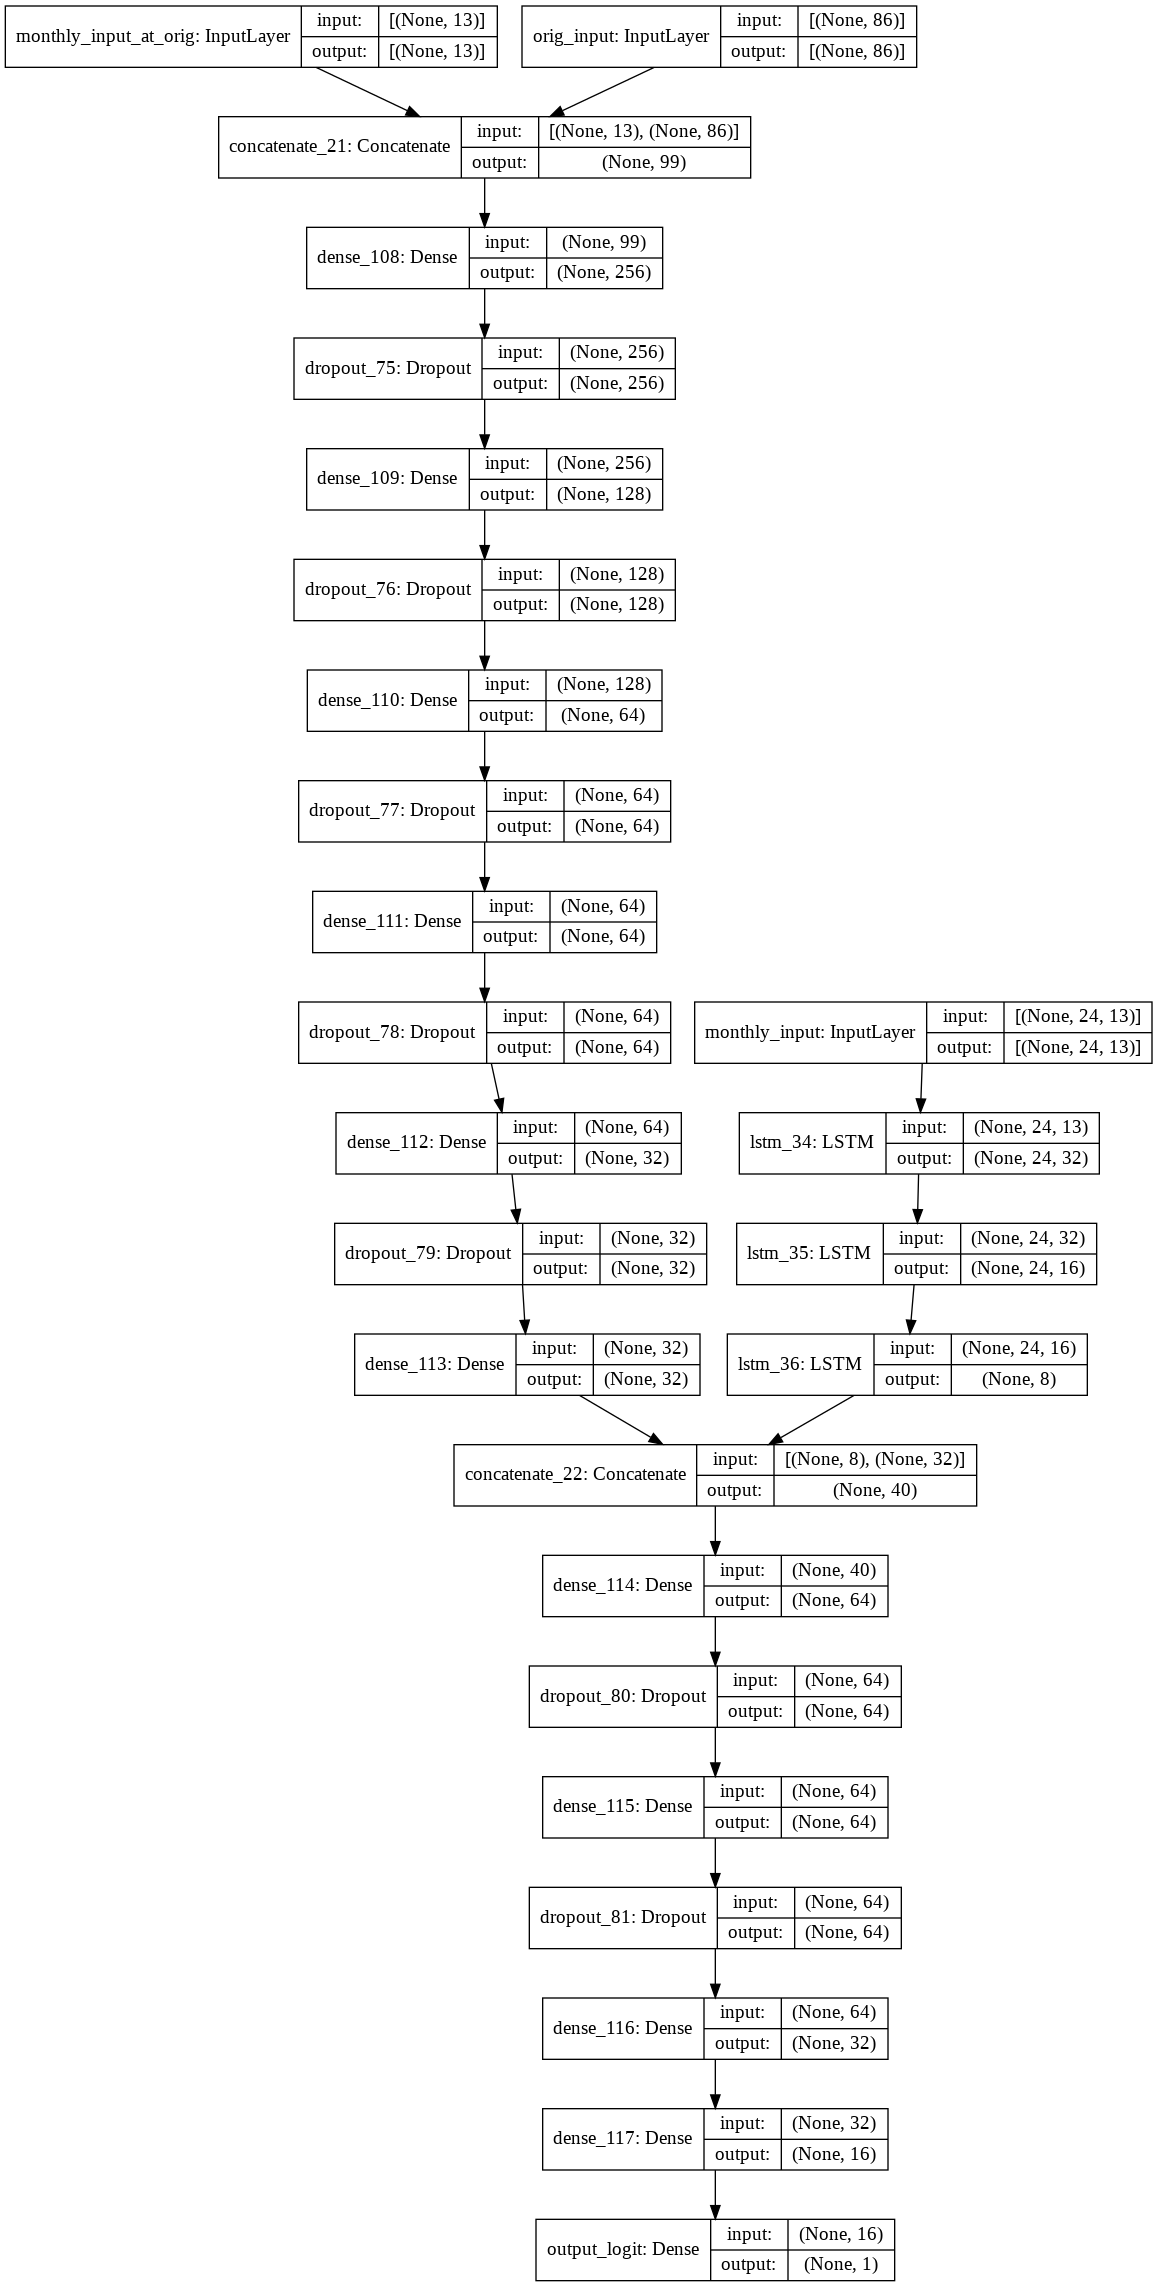

In [46]:
keras.utils.plot_model(model, show_shapes=True)

#### Evaluation on a loan from test dataset

In [47]:
dir_data_sheet = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/web_presentation/data_sheets"

In [48]:
np.random.seed(0)
rand_loan_id = np.random.choice(test_loan_id, 1, replace=False)[0]
selected_indexes = mapper_loan_id_test_idx[rand_loan_id]
print("rand_loan_id", rand_loan_id)

selected_monthly_data = test_monthly_data[selected_indexes]
selected_monthly_init_data = test_monthly_init_data[selected_indexes]
selected_orig_data = test_orig_data[selected_indexes]
selected_target_data = test_target_data[selected_indexes]
selected_len = len(selected_indexes)
rep_periods = df_combined.loc[df_combined['loan_id']==rand_loan_id, 'rep_period_plot'].dt.strftime("%Y-%m")
selected_rep_periods = rep_periods[:selected_len]

print("selected_monthly_data.shape", selected_monthly_data.shape)
print("selected_monthly_init_data.shape", selected_monthly_init_data.shape)
print("selected_orig_data.shape", selected_orig_data.shape)
print("selected_target_data.shape", selected_target_data.shape)
print("selected_len", selected_len)
if selected_target_data[0]==1.0:
    selected_true_label = "default"
else:
    selected_true_label = "prepaid or matured"
print("true label:", selected_target_data[0], selected_true_label)

rand_loan_id F18Q20187995
selected_monthly_data.shape (23, 24, 13)
selected_monthly_init_data.shape (23, 13)
selected_orig_data.shape (23, 86)
selected_target_data.shape (23,)
selected_len 23
true label: 0.0 prepaid or matured


In [49]:
test_logit = model.predict({"monthly_input": selected_monthly_data, 
                            "orig_input": selected_orig_data, 
                            "monthly_input_at_orig": selected_monthly_init_data}, 
                            batch_size=256)
test_proba = tf.math.sigmoid(test_logit).numpy().flatten()

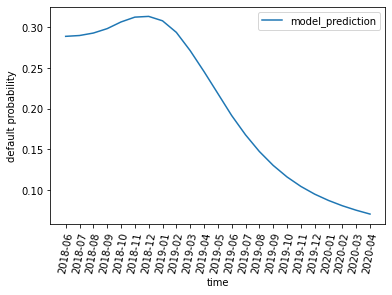

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
_ = ax.plot(np.arange(selected_len), test_proba, label="model_prediction")
_ = ax.set_xticks(np.arange(selected_len))
_ = ax.set_xticklabels(selected_rep_periods, Rotation=80)
_ = ax.set_ylabel("default probability")
_ = ax.set_xlabel("time")
_ = ax.legend()

In [51]:
df_example = df_combined.loc[df_combined['loan_id']==rand_loan_id, :]
df_example.to_csv(os.path.join(dir_data_sheet, "{}.csv".format(rand_loan_id)), 
                  index=False)
df_example

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,int_rate,est_ltv,delq_by_disaster,target,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_ind_sup_cfm,o_credit_score,o_dti,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct,o_chan_B,o_chan_C,o_chan_R,o_purp_C,o_purp_N,o_purp_P,o_first_flag_N,o_first_flag_Y,...,o_prop_st_KY,o_prop_st_LA,o_prop_st_MA,o_prop_st_MD,o_prop_st_ME,o_prop_st_MI,o_prop_st_MN,o_prop_st_MO,o_prop_st_MS,o_prop_st_MT,o_prop_st_NC,o_prop_st_ND,o_prop_st_NE,o_prop_st_NH,o_prop_st_NJ,o_prop_st_NM,o_prop_st_NV,o_prop_st_NY,o_prop_st_OH,o_prop_st_OK,o_prop_st_OR,o_prop_st_PA,o_prop_st_RI,o_prop_st_SC,o_prop_st_SD,o_prop_st_TN,o_prop_st_TX,o_prop_st_UT,o_prop_st_VA,o_prop_st_VT,o_prop_st_WA,o_prop_st_WI,o_prop_st_WV,o_prop_st_WY,o_prop_type_CO,o_prop_type_CP,o_prop_type_MH,o_prop_type_PU,o_prop_type_SF,rep_period_plot
507411,F18Q20187995,201806,308000.00,0,0,360,4.5,90.000000,0,NaN,201807,308000,25.0,90,4.5,0,787,28,252.31,252.31,3.0,3.0,0.01,3.50,4.55,4.55,3.2,1.5,1.3,1.3,1.000000,0.000000,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-06-01
508199,F18Q20187995,201807,307000.00,0,1,359,4.5,89.551624,0,NaN,201807,308000,25.0,90,4.5,0,787,28,252.75,252.31,2.9,3.0,-0.01,3.21,4.54,4.55,3.1,1.3,1.4,1.3,0.996753,0.002778,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-07-01
508200,F18Q20187995,201808,307000.00,0,2,358,4.5,89.551624,0,NaN,201807,308000,25.0,90,4.5,0,787,28,252.75,252.31,2.9,3.0,-0.01,3.21,4.52,4.55,3.1,1.3,1.4,1.3,0.996753,0.005556,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-08-01
508201,F18Q20187995,201809,306000.00,0,3,357,4.5,89.259925,0,NaN,201807,308000,25.0,90,4.5,0,787,28,252.75,252.31,2.8,3.0,-0.01,3.21,4.72,4.55,3.1,1.3,1.4,1.3,0.993506,0.008333,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-09-01
508958,F18Q20187995,201810,306000.00,0,4,356,4.5,88.403002,0,NaN,201807,308000,25.0,90,4.5,0,787,28,255.20,252.31,2.8,3.0,-0.02,2.97,4.86,4.55,3.0,1.5,1.3,1.3,0.993506,0.011111,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-10-01
508959,F18Q20187995,201811,306000.00,0,5,355,4.5,88.403002,0,NaN,201807,308000,25.0,90,4.5,0,787,28,255.20,252.31,2.8,3.0,-0.02,2.97,4.81,4.55,3.0,1.5,1.3,1.3,0.993506,0.013889,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-11-01
508960,F18Q20187995,201812,305000.00,0,6,354,4.5,88.114103,0,NaN,201807,308000,25.0,90,4.5,0,787,28,255.20,252.31,2.9,3.0,-0.02,2.97,4.55,4.55,3.0,1.5,1.3,1.3,0.990260,0.016667,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2018-12-01
509692,F18Q20187995,201901,304707.67,0,7,353,4.5,86.936135,0,NaN,201807,308000,25.0,90,4.5,0,787,28,258.41,252.31,2.9,3.0,-0.02,2.83,4.46,4.55,3.2,1.3,1.4,1.3,0.989311,0.019444,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019-01-01
509693,F18Q20187995,201902,304291.88,0,8,352,4.5,86.817506,0,NaN,201807,308000,25.0,90,4.5,0,787,28,258.41,252.31,2.9,3.0,-0.02,2.83,4.35,4.55,3.2,1.3,1.4,1.3,0.987961,0.022222,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019-02-01
509694,F18Q20187995,201903,303874.53,0,9,351,4.5,86.698432,0,NaN,201807,308000,25.0,90,4.5,0,787,28,258.41,252.31,2.9,3.0,-0.02,2.83,4.06,4.55,3.2,1.3,1.4,1.3,0.986606,0.025000,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019-03-01


In [52]:
np.random.seed(10)
rand_loan_id = np.random.choice(test_loan_id, 1, replace=False)[0]
selected_indexes = mapper_loan_id_test_idx[rand_loan_id]
print("rand_loan_id", rand_loan_id)

selected_monthly_data = test_monthly_data[selected_indexes]
selected_monthly_init_data = test_monthly_init_data[selected_indexes]
selected_orig_data = test_orig_data[selected_indexes]
selected_target_data = test_target_data[selected_indexes]
selected_len = len(selected_indexes)
rep_periods = df_combined.loc[df_combined['loan_id']==rand_loan_id, 'rep_period_plot'].dt.strftime("%Y-%m")
selected_rep_periods = rep_periods[:selected_len]

print("selected_monthly_data.shape", selected_monthly_data.shape)
print("selected_monthly_init_data.shape", selected_monthly_init_data.shape)
print("selected_orig_data.shape", selected_orig_data.shape)
print("selected_target_data.shape", selected_target_data.shape)
print("selected_len", selected_len)
if selected_target_data[0]==1.0:
    selected_true_label = "default"
else:
    selected_true_label = "prepaid or matured"
print("true label:", selected_target_data[0], selected_true_label)

rand_loan_id F19Q30196640
selected_monthly_data.shape (14, 24, 13)
selected_monthly_init_data.shape (14, 13)
selected_orig_data.shape (14, 86)
selected_target_data.shape (14,)
selected_len 14
true label: 1.0 default


In [53]:
test_logit = model.predict({"monthly_input": selected_monthly_data, 
                            "orig_input": selected_orig_data, 
                            "monthly_input_at_orig": selected_monthly_init_data}, 
                            batch_size=256)
test_proba = tf.math.sigmoid(test_logit).numpy().flatten()

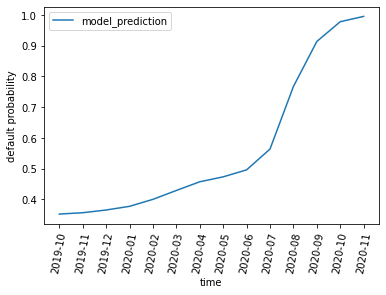

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
_ = ax.plot(np.arange(selected_len), test_proba, label="model_prediction")
_ = ax.set_xticks(np.arange(selected_len))
_ = ax.set_xticklabels(selected_rep_periods, Rotation=80)
_ = ax.set_ylabel("default probability")
_ = ax.set_xlabel("time")
_ = ax.legend()

In [55]:
test_proba

array([0.3526549 , 0.35700575, 0.36584887, 0.37777552, 0.40050054,
       0.42936796, 0.45752797, 0.47361022, 0.4962419 , 0.56393766,
       0.76704276, 0.9134164 , 0.9776618 , 0.99489707], dtype=float32)

In [56]:
df_example = df_combined.loc[df_combined['loan_id']==rand_loan_id, :]
df_example.to_csv(os.path.join(dir_data_sheet, "{}.csv".format(rand_loan_id)), 
                  index=False)
df_example

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,int_rate,est_ltv,delq_by_disaster,target,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_ind_sup_cfm,o_credit_score,o_dti,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct,o_chan_B,o_chan_C,o_chan_R,o_purp_C,o_purp_N,o_purp_P,o_first_flag_N,o_first_flag_Y,...,o_prop_st_KY,o_prop_st_LA,o_prop_st_MA,o_prop_st_MD,o_prop_st_ME,o_prop_st_MI,o_prop_st_MN,o_prop_st_MO,o_prop_st_MS,o_prop_st_MT,o_prop_st_NC,o_prop_st_ND,o_prop_st_NE,o_prop_st_NH,o_prop_st_NJ,o_prop_st_NM,o_prop_st_NV,o_prop_st_NY,o_prop_st_OH,o_prop_st_OK,o_prop_st_OR,o_prop_st_PA,o_prop_st_RI,o_prop_st_SC,o_prop_st_SD,o_prop_st_TN,o_prop_st_TX,o_prop_st_UT,o_prop_st_VA,o_prop_st_VT,o_prop_st_WA,o_prop_st_WI,o_prop_st_WV,o_prop_st_WY,o_prop_type_CO,o_prop_type_CP,o_prop_type_MH,o_prop_type_PU,o_prop_type_SF,rep_period_plot
758385,F19Q30196640,201910,138000.00,0,0,360,3.5,95.000000,0,NaN,201911,138000,30.0,95,3.5,0,768,33,246.82,246.82,3.4,3.4,-0.05,2.42,3.78,3.78,2.6,0.9,1.0,1.0,1.000000,0.000000,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-10-01
758386,F19Q30196640,201911,138000.00,0,1,359,3.5,95.000000,0,NaN,201911,138000,30.0,95,3.5,0,768,33,246.82,246.82,3.4,3.4,-0.05,2.42,3.68,3.78,2.6,0.9,1.0,1.0,1.000000,0.002778,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-11-01
758387,F19Q30196640,201912,137000.00,0,2,358,3.5,94.311594,0,NaN,201911,138000,30.0,95,3.5,0,768,33,246.82,246.82,3.5,3.4,-0.05,2.42,3.74,3.78,2.6,0.9,1.0,1.0,0.992754,0.005556,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-12-01
758675,F19Q30196640,202001,137000.00,0,3,357,3.5,91.732297,0,NaN,201911,138000,30.0,95,3.5,0,768,33,253.76,246.82,3.5,3.4,0.00,2.34,3.51,3.78,3.1,1.2,0.8,1.0,0.992754,0.008333,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-01-01
758676,F19Q30196640,202002,137000.00,1,4,356,3.5,91.732297,0,NaN,201911,138000,30.0,95,3.5,0,768,33,253.76,246.82,3.6,3.4,0.00,2.34,3.45,3.78,3.1,1.2,0.8,1.0,0.992754,0.011111,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-02-01
758677,F19Q30196640,202003,137000.00,0,5,355,3.5,91.732297,0,NaN,201911,138000,30.0,95,3.5,0,768,33,253.76,246.82,3.6,3.4,0.00,2.34,3.50,3.78,3.1,1.2,0.8,1.0,0.992754,0.013889,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-03-01
758905,F19Q30196640,202004,136000.00,0,6,354,3.5,89.656535,0,NaN,201911,138000,30.0,95,3.5,0,768,33,257.74,246.82,3.7,3.4,-0.05,2.39,3.23,3.78,2.8,1.1,0.7,1.0,0.985507,0.016667,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-04-01
758906,F19Q30196640,202005,136219.13,0,7,353,3.5,89.800994,0,NaN,201911,138000,30.0,95,3.5,0,768,33,257.74,246.82,12.5,3.4,-0.05,2.39,3.15,3.78,2.8,1.1,0.7,1.0,0.987095,0.019444,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-05-01
758907,F19Q30196640,202006,136219.13,1,8,352,3.5,89.800994,0,NaN,201911,138000,30.0,95,3.5,0,768,33,257.74,246.82,9.6,3.4,-0.05,2.39,3.13,3.78,2.8,1.1,0.7,1.0,0.987095,0.022222,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-06-01
759079,F19Q30196640,202007,136219.13,2,9,351,3.5,88.574139,0,NaN,201911,138000,30.0,95,3.5,0,768,33,261.31,246.82,8.1,3.4,0.00,2.52,2.99,3.78,1.5,0.9,0.8,1.0,0.987095,0.025000,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020-07-01


#### Overall Evaluation

In [57]:
test_logit = model.predict({"monthly_input": test_monthly_data, 
                            "orig_input": test_orig_data, 
                            "monthly_input_at_orig": test_monthly_init_data}, 
                            batch_size=256)
test_proba = tf.math.sigmoid(test_logit).numpy().flatten()
print("Overall evaluation results")
print('prc:', sklearn.metrics.average_precision_score(test_target_data, test_proba))
print('roc:', sklearn.metrics.roc_auc_score(test_target_data, test_proba))
print("precision:", sklearn.metrics.precision_score(test_target_data, np.round(test_proba)))
print("recall:", sklearn.metrics.recall_score(test_target_data, np.round(test_proba)))
print("f1_scores:", sklearn.metrics.f1_score(test_target_data, np.round(test_proba)))
print("accuracy:", sklearn.metrics.accuracy_score(test_target_data, np.round(test_proba)))

# rec_scores.append(sklearn.metrics.recall_score(y_true, np.round(y_pred_proba)))
# f1_scores.append(sklearn.metrics.f1_score(y_true, np.round(y_pred_proba)))
# acc_scores.append(sklearn.metrics.accuracy_score(y_true, np.round(y_pred_proba)))

# print('prc:', sklearn.metrics.average_precision_score(test_target_data, test_logit))
# print('roc:', sklearn.metrics.roc_auc_score(test_target_data, test_logit))

Overall evaluation results
prc: 0.9006501373803474
roc: 0.9053853950553732
precision: 0.9762993762993764
recall: 0.528471753319829
f1_scores: 0.6857476635514018
accuracy: 0.7951061601447206


#### Evaluation at Different Loan Ages

In [58]:
%%time
test_logits = defaultdict(list)
for k in range(len(test_loan_id)):
    loan_id = test_loan_id[k]
    selected_indexes = mapper_loan_id_test_idx[loan_id]
    # print("loan_id", loan_id, "age", len(selected_indexes))

    selected_monthly_data = test_monthly_data[selected_indexes]
    selected_orig_data = test_orig_data[selected_indexes]
    selected_monthly_at_orig_data = test_monthly_init_data[selected_indexes]
    selected_target_data = test_target_data[selected_indexes]
    logit = model.predict({"monthly_input": selected_monthly_data, 
                           "orig_input": selected_orig_data, 
                           "monthly_input_at_orig": selected_monthly_at_orig_data})
    proba = tf.math.sigmoid(logit).numpy().flatten().tolist()

    for i in range(len(selected_indexes)):
        test_logits[i].append([proba[i], selected_target_data[i]]) ## age (month): [pred_proba, target_class]


CPU times: user 24.4 s, sys: 1.16 s, total: 25.6 s
Wall time: 23.8 s


In [59]:
loan_ages = []
roc_scores = []
prc_scores = []
precision_scores = []
rec_scores = []
f1_scores = []
acc_scores = []
for age in sorted(test_logits):
    logits_target = np.array(test_logits[age])
    y_pred_proba = logits_target[:, 0]
    y_true = logits_target[:, 1]

    # print("age", age)
    # print("age", age, 
    #       "roc", my_roc_auc_score(y_true, y_pred_proba), 
    #       "prc", sklearn.metrics.average_precision_score(y_true, y_pred_proba))
    loan_ages.append(age)
    roc_scores.append(my_roc_auc_score(y_true, y_pred_proba))
    prc_scores.append(sklearn.metrics.average_precision_score(y_true, y_pred_proba))
    precision_scores.append(sklearn.metrics.precision_score(y_true, np.round(y_pred_proba)))
    rec_scores.append(sklearn.metrics.recall_score(y_true, np.round(y_pred_proba)))
    f1_scores.append(sklearn.metrics.f1_score(y_true, np.round(y_pred_proba)))
    acc_scores.append(sklearn.metrics.accuracy_score(y_true, np.round(y_pred_proba)))

loan_ages = np.array(loan_ages)
roc_scores = np.array(roc_scores)
prc_scores = np.array(prc_scores)
precision_scores = np.array(precision_scores)
rec_scores = np.array(rec_scores)
f1_scores = np.array(f1_scores)
acc_scores = np.array(acc_scores)

Text(0, 0.5, 'metrics')

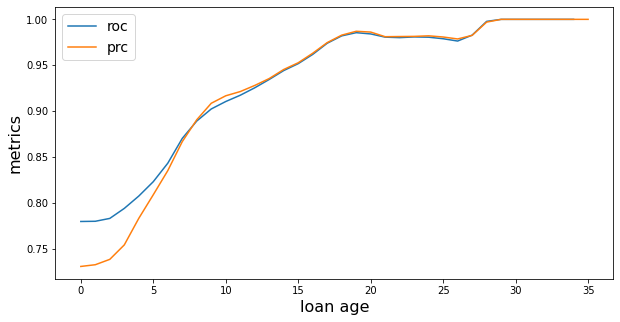

In [60]:
## metrics at different loan ages

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = ax.plot(loan_ages, roc_scores, label="roc")
_ = ax.plot(loan_ages, prc_scores, label="prc")
# _ = ax.plot(loan_ages, precision_scores, label="precision")
# _ = ax.plot(loan_ages, rec_scores, label="recall")
# _ = ax.plot(loan_ages, f1_scores, label="f1_score")
# _ = ax.plot(loan_ages, acc_scores, label="accuracy")

ax.legend(fontsize=14)
ax.set_xlabel("loan age", Fontsize=16)
ax.set_ylabel("metrics", Fontsize=16)


Text(0, 0.5, 'metrics')

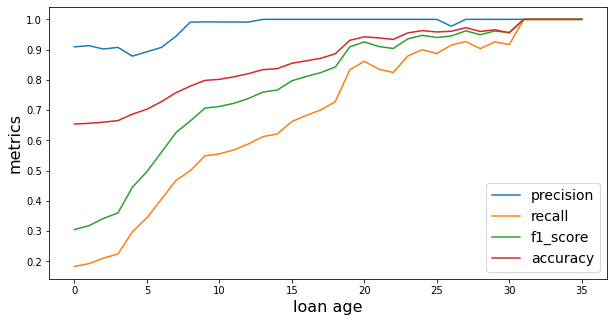

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# _ = ax.plot(loan_ages, roc_scores, label="roc")
# _ = ax.plot(loan_ages, prc_scores, label="prc")
_ = ax.plot(loan_ages, precision_scores, label="precision")
_ = ax.plot(loan_ages, rec_scores, label="recall")
_ = ax.plot(loan_ages, f1_scores, label="f1_score")
_ = ax.plot(loan_ages, acc_scores, label="accuracy")

ax.legend(fontsize=14)
ax.set_xlabel("loan age", Fontsize=16)
ax.set_ylabel("metrics", Fontsize=16)

In [62]:
roc_scores

array([0.77948886, 0.77971158, 0.78284434, 0.79376025, 0.80723206,
       0.82291082, 0.84304783, 0.87012498, 0.88907208, 0.90223977,
       0.91036988, 0.91721526, 0.92532776, 0.93443322, 0.94413039,
       0.9516781 , 0.96174636, 0.97393118, 0.98197701, 0.98547149,
       0.98410264, 0.98058437, 0.98006203, 0.98082596, 0.98052805,
       0.97885134, 0.97632979, 0.98278336, 0.99780059, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
              nan])

In [63]:
prc_scores

array([0.73043761, 0.73231824, 0.73817654, 0.75393749, 0.7829224 ,
       0.80866079, 0.83494536, 0.86657511, 0.8904854 , 0.90844952,
       0.91661717, 0.92121848, 0.92789739, 0.93543992, 0.94532036,
       0.95265547, 0.9630321 , 0.97463955, 0.98278831, 0.98698895,
       0.98612772, 0.98107049, 0.98125775, 0.98142129, 0.98203393,
       0.98074194, 0.97861906, 0.98252895, 0.99700438, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])